## Plot survival prediction results

In this notebook, we'll compare the results of survival prediction using [elastic net Cox regression](https://scikit-survival.readthedocs.io/en/stable/api/generated/sksurv.linear_model.CoxnetSurvivalAnalysis.html) for expression and methylation data only.

The files analyzed in this notebook are generated by the `run_survival_prediction.py` script.

Notebook parameters:
* SIG_ALPHA (float): significance cutoff for pairwise comparisons (after FDR correction)

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import mpmp.config as cfg
import mpmp.utilities.analysis_utilities as au
import mpmp.utilities.survival_utilities as su
import mpmp.utilities.plot_utilities as plu

%load_ext autoreload
%autoreload 2

### Parameters and data directories

In [2]:
# significance cutoff, after FDR correction
SIG_ALPHA = 0.05

# if True, save figures to images directory
SAVE_FIGS = True
images_dir = Path(cfg.images_dirs['survival'])

# set results directories
# TODO: document why these need to be different
me_pancancer_results_dir = Path(cfg.results_dirs['survival'], 'me_baseline_alphas')
all_pancancer_results_dir = Path(cfg.results_dirs['survival'], 'all_baseline_alphas')

me_pancancer_baseline_results_dir = Path(cfg.results_dirs['survival'], 'me_baseline', 'results_baseline')
all_pancancer_baseline_results_dir = Path(cfg.results_dirs['survival'], 'all_baseline', 'results_baseline')

me_cancer_type_results_dir = Path(cfg.results_dirs['survival'], 'me_ridge')
all_cancer_type_results_dir = Path(cfg.results_dirs['survival'], 'all_ridge')

me_cancer_type_baseline_results_dir = Path(cfg.results_dirs['survival'], 'me_ridge_baseline')
all_cancer_type_baseline_results_dir = Path(cfg.results_dirs['survival'], 'all_ridge_baseline')

# set list of PCA component numbers to look for
pancancer_pcs_list = [10, 100, 500, 1000, 5000]
cancer_type_n_pcs = 10

### Pan-cancer survival prediction, expression vs. methylation

These are models trained and tested on all data types in TCGA, for all samples that have expression and DNA methylation data profiled. We compare against a clinical covariate-only baseline (grey dotted line).

In [3]:
# order to plot data types in
training_data_map = {
    'expression': 'gene expression',
    'me_27k': '27k methylation',
    'me_450k': '450k methylation',
}

In [4]:
# get baseline predictor results, using non-omics covariates only
me_pancancer_df = []

for n_dim in pancancer_pcs_list:
    # load results into a single dataframe
    me_pcs_dir = Path(me_pancancer_results_dir, 'results_{}_pca'.format(n_dim))
    me_results_df = su.load_survival_results(me_pcs_dir)
    me_results_df.rename(columns={'identifier': 'cancer_type',
                                  'fold_no': 'fold'}, inplace=True)
    me_results_df['n_dim'] = n_dim
    me_pancancer_df.append(me_results_df)
    
me_pancancer_df = pd.concat(me_pancancer_df)
me_pancancer_df = (me_pancancer_df
      .loc[me_pancancer_df.cancer_type == 'pancancer', :]
      .reset_index(drop=True)
)
me_pancancer_df.training_data.replace(to_replace=training_data_map, inplace=True)

print(me_pancancer_df.shape)
print(me_pancancer_df.n_dim.unique())
print(me_pancancer_df.training_data.unique())
me_pancancer_df.head()

(720, 8)
[  10  100  500 1000 5000]
['gene expression' '27k methylation' '450k methylation']


,cindex,data_type,cancer_type,training_data,signal,seed,fold,n_dim
0,0.70265,train,pancancer,gene expression,shuffled,1,0,10
1,0.70265,cv,pancancer,gene expression,shuffled,1,0,10
2,0.68260,test,pancancer,gene expression,shuffled,1,0,10
3,0.70239,train,pancancer,gene expression,shuffled,1,1,10
4,0.70239,cv,pancancer,gene expression,shuffled,1,1,10


In [5]:
# get baseline predictor results, using non-omics covariates only
me_baseline_df = su.load_survival_results(me_pancancer_baseline_results_dir)
me_baseline_df.rename(columns={'identifier': 'cancer_type',
                               'fold_no': 'fold'}, inplace=True)
print(me_baseline_df.shape)
print(me_baseline_df.training_data.unique())
me_baseline_df.head()

(1512, 7)
['baseline']


,cindex,data_type,cancer_type,training_data,signal,seed,fold
0,0.58466,train,THCA,baseline,shuffled,42,0
1,0.58466,cv,THCA,baseline,shuffled,42,0
2,0.61196,test,THCA,baseline,shuffled,42,0
3,0.51766,train,THCA,baseline,shuffled,42,1
4,0.51766,cv,THCA,baseline,shuffled,42,1


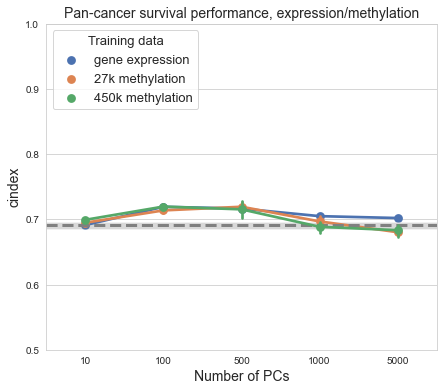

In [6]:
sns.set({'figure.figsize': (7, 6)})
sns.set_style('whitegrid')

sns.pointplot(data=me_pancancer_df,
              x='n_dim', y='cindex', hue='training_data', 
              hue_order=training_data_map.values())
plt.xlabel('Number of PCs', size=14)
plt.ylabel('cindex', size=14)
plt.legend(title='Training data', fontsize=13, title_fontsize=13, loc='upper left')
plt.title('Pan-cancer survival performance, expression/methylation', size=14)
plt.ylim(0.5, 1.0)

# plot baseline mean/bootstrapped 95% CI
baseline_vals = (me_baseline_df
    [(me_baseline_df.data_type == 'test') &
     (me_baseline_df.signal == 'signal') &
     (me_baseline_df.cancer_type == 'pancancer')]
).cindex.values

baseline_mean = np.mean(baseline_vals)
plt.gca().axhline(y=baseline_mean, linestyle='--', linewidth=3, color='gray')

baseline_ci = sns.utils.ci(
    sns.algorithms.bootstrap(baseline_vals,
                             func=np.mean,
                             n_boot=1000,
                             units=None,
                             seed=cfg.default_seed)
)
plt.gca().axhspan(baseline_ci[0], baseline_ci[1], facecolor='gray', alpha=0.3)

if SAVE_FIGS:
    images_dir.mkdir(exist_ok=True)
    plt.savefig(images_dir / 'me_pancan_survival.svg', bbox_inches='tight')
    plt.savefig(images_dir / 'me_pancan_survival.png',
                dpi=300, bbox_inches='tight')

### Pan-cancer survival prediction, all data types

These are models trained and tested on all data types in TCGA, for all samples that have all data types (expression, methylation, RPPA, miRNA, mutational signatures) data profiled. We compare against a clinical covariate-only baseline (grey dotted line).

In [7]:
# order to plot data types in
training_data_map = {
    'expression': 'gene expression',
    'me_27k': '27k methylation',
    'me_450k': '450k methylation',
    'rppa': 'RPPA',
    'mirna': 'microRNA',
    'mut_sigs': 'mutational signatures',
}

In [8]:
me_performance_df = []
all_drop_cancer_types = set()

me_pcs_dir = Path(me_cancer_type_results_dir, 'results_{}_pca'.format(cancer_type_n_pcs))
me_results_df = su.load_survival_results(me_pcs_dir)
me_results_df.rename(columns={'identifier': 'cancer_type',
                              'fold_no': 'fold'}, inplace=True)
    
me_performance_df = me_results_df[
    (me_results_df.data_type == 'test') &
    (me_results_df.signal == 'signal')
].copy()
me_performance_df.drop(columns=['data_type', 'signal'], inplace=True)
me_performance_df.training_data.replace(to_replace=training_data_map, inplace=True)

me_performance_df.head(10)

,cindex,cancer_type,training_data,seed,fold
2,0.22137,PCPG,gene expression,1,0
5,0.47368,PCPG,gene expression,1,1
8,0.57547,PCPG,gene expression,1,2
11,0.50000,PCPG,gene expression,1,3
2,0.42082,COAD,27k methylation,1,0
5,0.53786,COAD,27k methylation,1,1
8,0.45229,COAD,27k methylation,1,2
11,0.47810,COAD,27k methylation,1,3
2,0.69856,pancancer,gene expression,42,0
5,0.70970,pancancer,gene expression,42,1


In [9]:
# get baseline predictor results, using non-omics covariates only
all_pancancer_df = []

for n_dim in pancancer_pcs_list:
    # load results into a single dataframe
    all_pcs_dir = Path(all_pancancer_results_dir, 'results_{}_pca'.format(n_dim))
    all_results_df = su.load_survival_results(all_pcs_dir)
    all_results_df.rename(columns={'identifier': 'cancer_type',
                                  'fold_no': 'fold'}, inplace=True)
    all_results_df['n_dim'] = n_dim
    all_pancancer_df.append(all_results_df)
    
all_pancancer_df = pd.concat(all_pancancer_df)
all_pancancer_df = (all_pancancer_df
      .loc[all_pancancer_df.cancer_type == 'pancancer', :]
      .reset_index(drop=True)
)
all_pancancer_df.training_data.replace(to_replace=training_data_map, inplace=True)

print(all_pancancer_df.shape)
print(all_pancancer_df.n_dim.unique())
print(all_pancancer_df.training_data.unique())
all_pancancer_df.head()

(1440, 8)
[  10  100  500 1000 5000]
['gene expression' '27k methylation' '450k methylation' 'microRNA' 'RPPA'
 'mutational signatures']


,cindex,data_type,cancer_type,training_data,signal,seed,fold,n_dim
0,0.70935,train,pancancer,gene expression,shuffled,1,0,10
1,0.70935,cv,pancancer,gene expression,shuffled,1,0,10
2,0.70618,test,pancancer,gene expression,shuffled,1,0,10
3,0.70786,train,pancancer,gene expression,shuffled,1,1,10
4,0.70786,cv,pancancer,gene expression,shuffled,1,1,10


In [10]:
# get baseline predictor results, using non-omics covariates only
all_baseline_df = su.load_survival_results(all_pancancer_baseline_results_dir)
all_baseline_df.rename(columns={'identifier': 'cancer_type',
                               'fold_no': 'fold'}, inplace=True)
print(all_baseline_df.shape)
print(all_baseline_df.training_data.unique())
all_baseline_df.head()

(1272, 7)
['baseline']


,cindex,data_type,cancer_type,training_data,signal,seed,fold
0,0.52001,train,THCA,baseline,shuffled,42,0
1,0.52001,cv,THCA,baseline,shuffled,42,0
2,0.27595,test,THCA,baseline,shuffled,42,0
3,0.61423,train,THCA,baseline,shuffled,42,1
4,0.61423,cv,THCA,baseline,shuffled,42,1


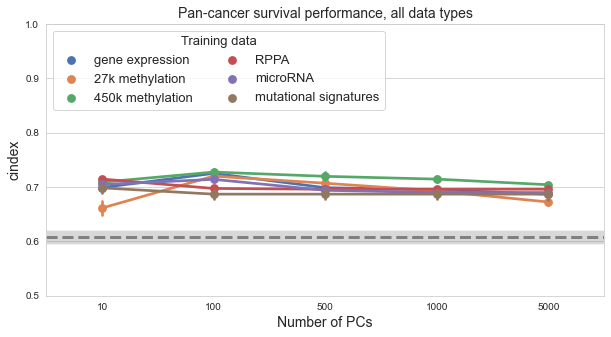

In [11]:
sns.set({'figure.figsize': (10, 5)})
sns.set_style('whitegrid')

sns.pointplot(data=all_pancancer_df,
              x='n_dim', y='cindex', hue='training_data', 
              hue_order=training_data_map.values())
plt.xlabel('Number of PCs', size=14)
plt.ylabel('cindex', size=14)
plt.legend(title='Training data', fontsize=13, title_fontsize=13, loc='upper left', ncol=2)
plt.title('Pan-cancer survival performance, all data types', size=14)
plt.ylim(0.5, 1.0)

# plot baseline mean/bootstrapped 95% CI
baseline_vals = (all_baseline_df
    [(all_baseline_df.data_type == 'test') &
     (all_baseline_df.signal == 'signal') &
     (all_baseline_df.cancer_type == 'pancancer')]
).cindex.values

baseline_mean = np.mean(baseline_vals)
plt.gca().axhline(y=baseline_mean, linestyle='--', linewidth=3, color='gray')

baseline_ci = sns.utils.ci(
    sns.algorithms.bootstrap(baseline_vals,
                             func=np.mean,
                             n_boot=1000,
                             units=None,
                             seed=cfg.default_seed)
)
plt.gca().axhspan(baseline_ci[0], baseline_ci[1], facecolor='gray', alpha=0.3)

if SAVE_FIGS:
    plt.savefig(images_dir / 'all_pancan_survival.svg', bbox_inches='tight')
    plt.savefig(images_dir / 'all_pancan_survival.png',
                dpi=300, bbox_inches='tight')

### Individual cancer survival prediction, expression vs. methylation

These are models trained and tested on each individual data type in TCGA, for all samples that have expression and DNA methylation data profiled. Like before, grey dotted lines are clinical covariate-only baselines, for that specific cancer type.

We only ran these experiments using 10 principal components extracted from the -omics datasets, since using more PCs than that led to convergence issues on many cancer types.

In [12]:
# order to plot data types in
training_data_map = {
    'expression': 'gene expression',
    'me_27k': '27k methylation',
    'me_450k': '450k methylation',
}

In [13]:
me_performance_df = []
all_drop_cancer_types = set()

me_pcs_dir = Path(me_cancer_type_results_dir, 'results_{}_pca'.format(cancer_type_n_pcs))
me_results_df = su.load_survival_results(me_pcs_dir)
me_results_df.rename(columns={'identifier': 'cancer_type',
                              'fold_no': 'fold'}, inplace=True)
    
me_performance_df = me_results_df[
    (me_results_df.data_type == 'test') &
    (me_results_df.signal == 'signal')
].copy()
me_performance_df.drop(columns=['data_type', 'signal'], inplace=True)
me_performance_df.training_data.replace(to_replace=training_data_map, inplace=True)

me_performance_df.head(10)

,cindex,cancer_type,training_data,seed,fold
2,0.22137,PCPG,gene expression,1,0
5,0.47368,PCPG,gene expression,1,1
8,0.57547,PCPG,gene expression,1,2
11,0.50000,PCPG,gene expression,1,3
2,0.42082,COAD,27k methylation,1,0
5,0.53786,COAD,27k methylation,1,1
8,0.45229,COAD,27k methylation,1,2
11,0.47810,COAD,27k methylation,1,3
2,0.69856,pancancer,gene expression,42,0
5,0.70970,pancancer,gene expression,42,1


In [14]:
group_cancer_types = me_performance_df.groupby(['cancer_type']).count().seed
max_count = group_cancer_types.max()
valid_cancer_types = group_cancer_types[group_cancer_types == max_count].index
print(valid_cancer_types)

Index(['ACC', 'BLCA', 'BRCA', 'CESC', 'CHOL', 'COAD', 'ESCA', 'GBM', 'HNSC',
       'KIRC', 'KIRP', 'LAML', 'LGG', 'LIHC', 'LUAD', 'LUSC', 'MESO', 'PAAD',
       'PCPG', 'PRAD', 'READ', 'SARC', 'SKCM', 'STAD', 'TGCT', 'THCA', 'THYM',
       'UCEC', 'UCS', 'UVM', 'pancancer'],
      dtype='object', name='cancer_type')


In [15]:
cancer_type_avg = (
    me_performance_df[me_performance_df.cancer_type.isin(valid_cancer_types)]
      .groupby('cancer_type')
      .mean()
).cindex
cancer_type_avg.sort_values(ascending=False).head(10)

cancer_type
ACC          0.787615
KIRP         0.774851
UVM          0.706037
LGG          0.701642
pancancer    0.701566
KIRC         0.695271
SARC         0.662118
MESO         0.656959
LAML         0.646613
UCEC         0.646043
Name: cindex, dtype: float64

In [16]:
cancer_type_sd = me_performance_df.groupby('cancer_type').std().cindex
cancer_type_cv = cancer_type_avg / cancer_type_sd
cancer_type_cv.sort_values(ascending=False).head(10)

cancer_type
pancancer    87.218126
HNSC         19.691858
LGG          18.439578
SKCM         16.837355
LAML         14.909855
BLCA         12.938019
SARC         12.758226
MESO         12.239990
UCEC         11.827010
KIRC         11.236107
Name: cindex, dtype: float64

In [17]:
# get baseline predictor results, using non-omics covariates only
me_baseline_df = su.load_survival_results(me_cancer_type_baseline_results_dir)
me_baseline_df.rename(columns={'identifier': 'cancer_type',
                               'fold_no': 'fold'}, inplace=True)
print(me_baseline_df.shape)
print(me_baseline_df.training_data.unique())
me_baseline_df.head()

(1512, 7)
['baseline']


,cindex,data_type,cancer_type,training_data,signal,seed,fold
0,0.58652,train,THCA,baseline,shuffled,42,0
1,0.58652,cv,THCA,baseline,shuffled,42,0
2,0.62935,test,THCA,baseline,shuffled,42,0
3,0.51779,train,THCA,baseline,shuffled,42,1
4,0.51779,cv,THCA,baseline,shuffled,42,1


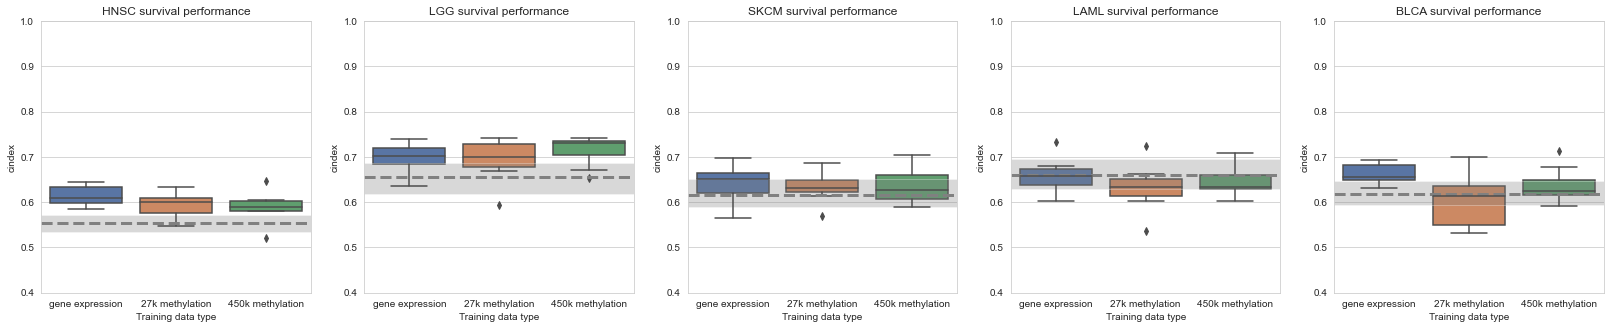

In [18]:
sns.set({'figure.figsize': (28, 5)})
sns.set_style('whitegrid')
fig, axarr = plt.subplots(1, 5)

cancer_type_cv = cancer_type_cv[cancer_type_cv.index != 'pancancer']
for ix, cancer_type in enumerate(cancer_type_cv.sort_values(ascending=False).index[:5]):
    ax = axarr[ix]
    sns.boxplot(data=me_performance_df[me_performance_df.cancer_type == cancer_type],
                x='training_data', y='cindex', order=training_data_map.values(), ax=ax)
    ax.set_xlabel('Training data type')
    ax.set_ylabel('cindex')
    ax.set_title('{} survival performance'.format(cancer_type))
    ax.set_ylim(0.4, 1.0)
        
    # plot baseline mean/bootstrapped 95% CI
    baseline_vals = (me_baseline_df
        [(me_baseline_df.data_type == 'test') &
         (me_baseline_df.signal == 'signal') &
         (me_baseline_df.cancer_type == cancer_type)]
    ).cindex.values

    baseline_mean = np.mean(baseline_vals)
    ax.axhline(y=baseline_mean, linestyle='--', linewidth=3, color='gray')

    baseline_ci = sns.utils.ci(
        sns.algorithms.bootstrap(baseline_vals,
                                 func=np.mean,
                                 n_boot=1000,
                                 units=None,
                                 seed=cfg.default_seed)
    )
    ax.axhspan(baseline_ci[0], baseline_ci[1], facecolor='gray', alpha=0.3)
        
if SAVE_FIGS:
    plt.savefig(images_dir / 'me_top_cancers_survival.svg', bbox_inches='tight')
    plt.savefig(images_dir / 'me_top_cancers_survival.png',
                dpi=300, bbox_inches='tight')

Text(0.5, 1.0, 'Performance for varying PC count, averaged over cancer types')

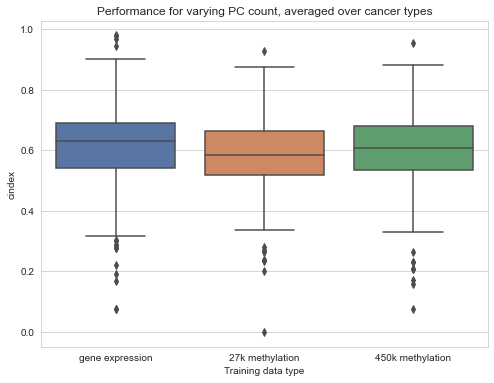

In [19]:
sns.set({'figure.figsize': (8, 6)})
sns.set_style('whitegrid')

sns.boxplot(data=me_performance_df, x='training_data', y='cindex',
            order=training_data_map.values())
plt.xlabel('Training data type')
plt.ylabel('cindex')
plt.title('Performance for varying PC count, averaged over cancer types')

### Individual cancer survival prediction, all data types

These are models trained and tested on each individual data type in TCGA, for all samples that have all data types (expression, methylation, RPPA, miRNA, mutational signatures) data profiled. Like before, grey dotted lines are clinical covariate-only baselines, for that specific cancer type.

We only ran these experiments using 10 principal components extracted from the -omics datasets, since using more PCs than that led to convergence issues on many cancer types.

In [20]:
# order to plot data types in
training_data_map = {
    'expression': 'gene expression',
    'me_27k': '27k methylation',
    'me_450k': '450k methylation',
    'rppa': 'RPPA',
    'mirna': 'microRNA',
    'mut_sigs': 'mutational signatures',
}

In [21]:
all_performance_df = []
all_drop_cancer_types = set()

all_pcs_dir = Path(all_cancer_type_results_dir, 'results_{}_pca'.format(cancer_type_n_pcs))
all_results_df = su.load_survival_results(all_pcs_dir)
all_results_df.rename(columns={'identifier': 'cancer_type',
                              'fold_no': 'fold'}, inplace=True)
    
all_performance_df = all_results_df[
    (all_results_df.data_type == 'test') &
    (all_results_df.signal == 'signal')
].copy()
all_performance_df.drop(columns=['data_type', 'signal'], inplace=True)
all_performance_df.training_data.replace(to_replace=training_data_map, inplace=True)

all_performance_df.head(10)

,cindex,cancer_type,training_data,seed,fold
2,0.69831,LGG,RPPA,1,0
5,0.67304,LGG,RPPA,1,1
8,0.65561,LGG,RPPA,1,2
11,0.67382,LGG,RPPA,1,3
2,0.44186,UCS,RPPA,42,0
5,0.42623,UCS,RPPA,42,1
8,0.68889,UCS,RPPA,42,2
11,0.71053,UCS,RPPA,42,3
2,0.64181,PRAD,RPPA,1,0
5,0.56930,PRAD,RPPA,1,1


In [22]:
group_cancer_types = all_performance_df.groupby(['cancer_type']).count().seed
max_count = group_cancer_types.max()
valid_cancer_types = group_cancer_types[group_cancer_types == max_count].index
print(valid_cancer_types)

Index(['ACC', 'BLCA', 'BRCA', 'CHOL', 'COAD', 'ESCA', 'HNSC', 'KIRC', 'KIRP',
       'LGG', 'LIHC', 'LUAD', 'LUSC', 'MESO', 'PAAD', 'PRAD', 'SARC', 'SKCM',
       'STAD', 'TGCT', 'THCA', 'THYM', 'UCEC', 'UCS', 'pancancer'],
      dtype='object', name='cancer_type')


In [23]:
cancer_type_avg = (
    all_performance_df[all_performance_df.cancer_type.isin(valid_cancer_types)]
      .groupby('cancer_type')
      .mean()
).cindex
cancer_type_avg.sort_values(ascending=False).head(10)

cancer_type
KIRP         0.736007
pancancer    0.707159
LGG          0.676414
ACC          0.676114
KIRC         0.655279
UCEC         0.649471
SARC         0.626688
SKCM         0.621989
BLCA         0.602870
LIHC         0.584947
Name: cindex, dtype: float64

In [24]:
cancer_type_sd = all_performance_df.groupby('cancer_type').std().cindex
cancer_type_cv = cancer_type_avg / cancer_type_sd
cancer_type_cv.sort_values(ascending=False).head(10)

cancer_type
pancancer    59.532981
HNSC          9.924751
SKCM          9.586944
BLCA          8.575206
PAAD          8.458486
LUSC          8.169642
LUAD          7.945651
KIRC          7.812007
STAD          7.615353
LGG           7.337005
Name: cindex, dtype: float64

In [25]:
# get baseline predictor results, using non-omics covariates only
all_baseline_df = su.load_survival_results(all_cancer_type_baseline_results_dir)
all_baseline_df.rename(columns={'identifier': 'cancer_type',
                               'fold_no': 'fold'}, inplace=True)
print(all_baseline_df.shape)
print(all_baseline_df.training_data.unique())
all_baseline_df.head()

(1272, 7)
['baseline']


,cindex,data_type,cancer_type,training_data,signal,seed,fold
0,0.52347,train,THCA,baseline,shuffled,42,0
1,0.52347,cv,THCA,baseline,shuffled,42,0
2,0.27342,test,THCA,baseline,shuffled,42,0
3,0.61836,train,THCA,baseline,shuffled,42,1
4,0.61836,cv,THCA,baseline,shuffled,42,1


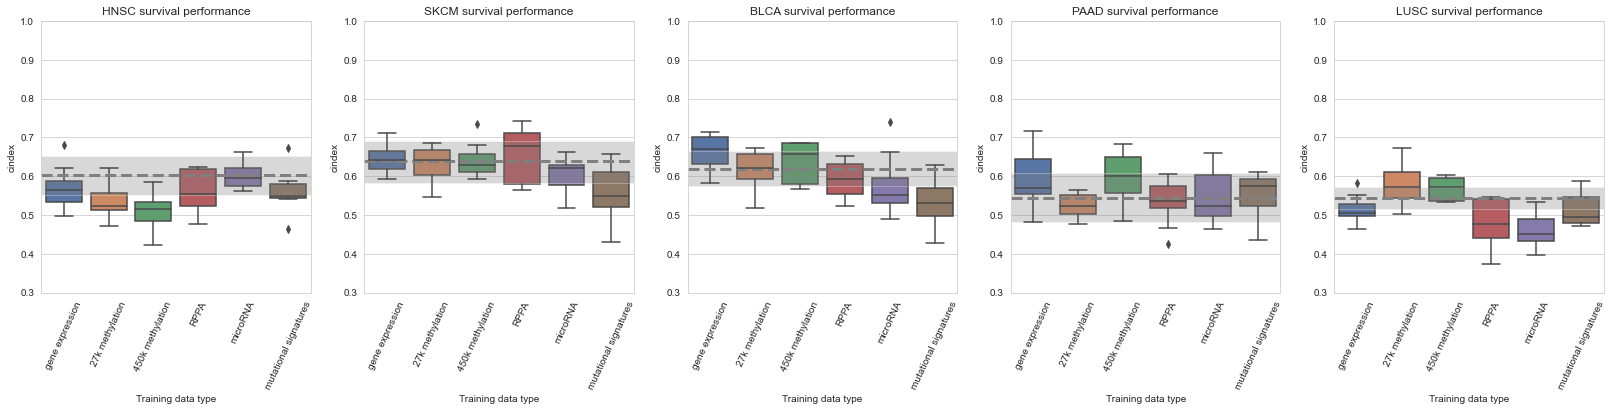

In [26]:
sns.set({'figure.figsize': (28, 5)})
sns.set_style('whitegrid')
fig, axarr = plt.subplots(1, 5)

cancer_type_cv = cancer_type_cv[cancer_type_cv.index != 'pancancer']
for ix, cancer_type in enumerate(cancer_type_cv.sort_values(ascending=False).index[:5]):
    ax = axarr[ix]
    sns.boxplot(data=all_performance_df[all_performance_df.cancer_type == cancer_type],
                x='training_data', y='cindex', order=training_data_map.values(), ax=ax)
    ax.set_xlabel('Training data type')
    for label in ax.get_xticklabels():
        label.set_rotation(65)
    ax.set_ylabel('cindex')
    ax.set_title('{} survival performance'.format(cancer_type))
    ax.set_ylim(0.3, 1.0)
        
    # plot baseline mean/bootstrapped 95% CI
    baseline_vals = (all_baseline_df
        [(all_baseline_df.data_type == 'test') &
         (all_baseline_df.signal == 'signal') &
         (all_baseline_df.cancer_type == cancer_type)]
    ).cindex.values

    baseline_mean = np.mean(baseline_vals)
    ax.axhline(y=baseline_mean, linestyle='--', linewidth=3, color='gray')

    baseline_ci = sns.utils.ci(
        sns.algorithms.bootstrap(baseline_vals,
                                 func=np.mean,
                                 n_boot=1000,
                                 units=None,
                                 seed=cfg.default_seed)
    )
    ax.axhspan(baseline_ci[0], baseline_ci[1], facecolor='gray', alpha=0.3)
        
if SAVE_FIGS:
    plt.savefig(images_dir / 'all_top_cancers_survival.svg', bbox_inches='tight')
    plt.savefig(images_dir / 'all_top_cancers_survival.png',
                dpi=300, bbox_inches='tight')

Text(0.5, 1.0, 'Performance for varying PC count, averaged over cancer types')

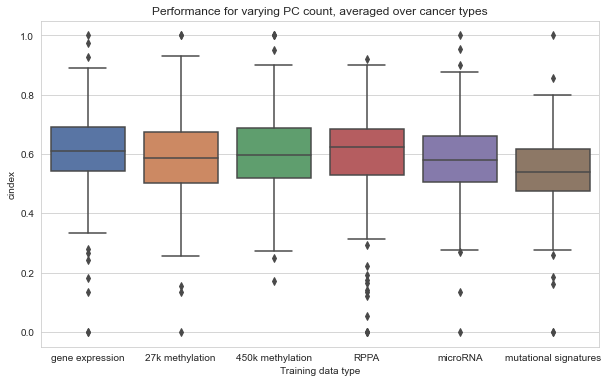

In [27]:
sns.set({'figure.figsize': (10, 6)})
sns.set_style('whitegrid')

sns.boxplot(data=all_performance_df, x='training_data', y='cindex',
            order=training_data_map.values())
plt.xlabel('Training data type')
plt.ylabel('cindex')
plt.title('Performance for varying PC count, averaged over cancer types')